In [46]:
from numpy import genfromtxt
import numpy as np
import random
import networkx as nx
import math
import itertools    
import matplotlib.pyplot as plt
import csv
from sklearn import manifold
from itertools import tee
from itertools import zip_longest as zip
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import matplotlib.patches as mpatches

In [47]:
horizon1 = 540
list_of_day = ['Day_route_Feb04.dat']

def get_solution(data, manager, routing, assignment):
    time_dimension = routing.GetDimensionOrDie('Time')

    main_list = []
    
    for vehicle_id in range(len(data["start_location"])):
        
        my_dict = {}
        my_dict["vehicle_id"] = vehicle_id
        
        route = []
        timer = []
        index = routing.Start(vehicle_id)
        temp = index
        
        while not routing.IsEnd(index):

            node_index = manager.IndexToNode(index)
            route.append(node_index)
            
            time_var = time_dimension.CumulVar(index)
            time_min = assignment.Min(time_var)
            time_max = assignment.Max(time_var)
            timer.append((time_min, time_max))
            
            index = assignment.Value(routing.NextVar(index))
            
        route.append(temp)
        
        time_var = time_dimension.CumulVar(index)
        time_min = assignment.Min(time_var)
        time_max = assignment.Max(time_var)
        timer.append((time_min, time_max))
        
        my_dict["route"] = route
        my_dict["timer"] = timer
        
        
        main_list.append(my_dict)
        
    return main_list

def create_data_model(file_name):

    thread = '/Users/animeshgoyal/Desktop/UT_2nd SEM/Applied Project_Zillow/drive-download-20190308T035948Z-001/'
    data_in = open(thread + file_name, "rb")

    visits_data = pickle.load(data_in)
    vehicles_data = pickle.load(data_in)
    travel_dist = pickle.load(data_in)
    travel_time = pickle.load(data_in)
    total_miles = pickle.load(data_in)

    extra_vehicles = 0
    data_in.close()

    # Creating a distance matrix to be supplied to routing model.
    # Defines distance between 2 location in a matrix.

    number_of_nodes = int(math.sqrt(len(travel_dist)))
    final_distance_matrix = []
    for i in range(number_of_nodes):
        temp_distance_matrix = []
        for j in range(number_of_nodes):
            temp_distance_matrix.append(travel_dist[(i, j)])
        final_distance_matrix.append(temp_distance_matrix)

    # Creating a travel time matrix to be supplied to routing model.
    # Defines travel time between 2 locations in a matrix

    final_time_matrix = []
    for i in range(number_of_nodes):
        temp_time_matrix = []
        for j in range(number_of_nodes):
            temp_time_matrix.append(travel_time[(i, j)])
        final_time_matrix.append(temp_time_matrix)

    # Creating a demand list to be supplied to routing model.
    # Demand for depots was set to 0

    list_of_nodes = []
    for i in visits_data:
        for j in visits_data[i]:
            list_of_nodes.append((j[1], j[2], j[0]))
    list_of_nodes = sorted(list_of_nodes, key=lambda x: x[0])  # Got the unique # of nodes to be visited with visit_type
    demand_list = [0] * len(list_of_nodes)  # demand list mapping time units to each type of the visit in below loop

    for i in visits_data:
        for j in visits_data[i]:
            if (j[2] == 'sfw'):
                demand_list[j[1]] = 30
            elif (j[2] == 'progress walk'):
                demand_list[j[1]] = 30
            elif (j[2] == 'initial walk'):
                demand_list[j[1]] = 60
            else:
                demand_list[j[1]] = 60

    # Adding 0 demands of depots and demand list is ready
    demand_list = demand_list + [0] * len(visits_data)

    # creating a time window tuple list. Only SFW has strict time window.
    # Rest all available in entire horizon

    time_windows_list = []

    for i in range(len(demand_list)):
        time_windows_list.append([0, horizon1])

    # In entire demand list, we traverse only to first main nodes elements and let others remain untouched.
    for i in range(len(list_of_nodes)):
        if (list_of_nodes[i][1] == 'sfw'):
            # if (1 == 1):
            time_windows_list[i][0] = list_of_nodes[i][2]
            time_windows_list[i][1] = list_of_nodes[i][2]

        else:
            # if (1 == 1):
            time_windows_list[i][0] = 0
            time_windows_list[i][1] = horizon1

    for i in range(len(time_windows_list)):
        time_windows_list[i] = tuple(time_windows_list[i])

    time_windows_list_homeonly = time_windows_list[:len(list_of_nodes)]  # only  nodes to be visited

    # location assginment
    locations_assigned = {}

    for i in visits_data:
        for j in visits_data[i]:
            if (j[2] != 'sfw'):
                if i in locations_assigned.keys():
                    locations_assigned[i].append(int(j[1]))
                else:
                    locations_assigned[i] = []
                    locations_assigned[i].append(int(j[1]))

    # Preparing input data for the model
    data = {}

    data["distances"] = final_distance_matrix
    data["travel_time"] = final_time_matrix
    data["demands"] = demand_list
    data["time_windows"] = time_windows_list
    data["time_windows_home"] = time_windows_list_homeonly
    data["num_locations"] = len(final_distance_matrix)
    data["num_vehicles"] = len(visits_data)
    data["time_per_demand_unit"] = 1
    data["list_of_nodes"] = list_of_nodes

    start = len(demand_list) - len(visits_data)
    end = len(demand_list)

    data["start_location"] = list(range(start, end))
    data["end_location"] = list(range(start, end))
    data["super_jobs"] = locations_assigned

    if (extra_vehicles != 0):
        data["start_location"] = list(range(start, end)) + [start] * extra_vehicles
        data["end_location"] = list(range(start, end)) + [start] * extra_vehicles

    data["initial_assignments"] = visits_data  # used when initial assignment needs to be done



    
    return data, list_of_nodes

def assign_morning_sfw(data):  # same as 6.10
    route_assignment = data["initial_assignments"]
    initial_routes = []

    for key in route_assignment.keys():
        jobs = []

        for i in range(len(route_assignment[key])):
            jobs.append(route_assignment[key][i][1])
        initial_routes.append(jobs)

    return initial_routes

def print_solution(data, manager, routing, assignment):

    # Inspect solution.

    time_dimension = routing.GetDimensionOrDie('Time')
    total_dist = 0
    time_matrix = 0

    for vehicle_id in range(len(data["start_location"])):

        index = routing.Start(vehicle_id)
        plan_output = '\nRoute for vehicle {0}:\n'.format(vehicle_id)
        route_dist = 0

        while not routing.IsEnd(index):

            node_index = manager.IndexToNode(index)
            next_node_index = manager.IndexToNode(assignment.Value(routing.NextVar(index)))
            route_dist += routing.GetArcCostForVehicle(node_index, next_node_index, vehicle_id)
            time_var = time_dimension.CumulVar(index)
            time_min = assignment.Min(time_var)
            time_max = assignment.Max(time_var)
            plan_output += ' {0} Time({1},{2}) ->'.format(node_index, time_min, time_max)
            index = assignment.Value(routing.NextVar(index))

        node_index = manager.IndexToNode(index)
        time_var = time_dimension.CumulVar(index)
        route_time = assignment.Value(time_var)
        time_min = assignment.Min(time_var)
        time_max = assignment.Max(time_var)
        total_dist += route_dist
        time_matrix += route_time

        plan_output += ' {0} Time({1},{2})\n'.format(node_index, time_min, time_max)
        plan_output += 'Distance of the route: {0} m\n'.format(route_dist)
        plan_output += 'Time of the route: {0} min\n'.format(route_time)
        print(plan_output)

    print('Total Distance of all routes: {0} m'.format(total_dist))
    print('Total Time of all routes: {0} min'.format(time_matrix))
    return (total_dist, time_matrix)

def add_super_job_constraints(routing, manager, data):
    jobs_assigned = data["super_jobs"]
    for key in jobs_assigned.keys():
        for num_addresses in range(len(jobs_assigned[key])):
            routing.VehicleVar(manager.NodeToIndex(jobs_assigned[key][num_addresses])).SetValues([-1, key]) # Laurent's code
            #routing.VehicleVar(manager.NodeToIndex(jobs_assigned[key][num_addresses])).SetValue(key)

def create_distance_callback(data, manager):
    distances = data['distances']

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)

        return distances[from_node][to_node]

    return distance_callback

def create_time_callback(data, manager):

    def service_time(node):
        this_node = manager.IndexToNode(node)
        return data["demands"][this_node]  # data["time_per_demand_unit"]

    def travel_time(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        travel_time = data["travel_time"][from_node][to_node]
        return travel_time

    def time_callback(from_index, to_index):
        serv_time = service_time(from_index)
        trav_time = travel_time(from_index, to_index)
        return serv_time + trav_time

    return time_callback

def add_time_window_constraints(routing, manager, data, time_callback):
    time = "Time"
    horizon = horizon1
    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_callback_index, horizon, horizon, True, time)

    time_dimension = routing.GetDimensionOrDie(time)

    # Set timewindow_all = Fale to remove timewindows for progress walk and depot locations
    timewindow_all = False
    if timewindow_all:
        for location_node, location_time_window in enumerate(data["time_windows"]):
            index = manager.NodeToIndex(location_node)

            # Case of the depot
            if (location_node >= (len(data["time_windows"]) - len(data["start_location"]))):
                time_dimension.CumulVar(index).SetRange(location_time_window[0], location_time_window[1])

            # Case of main nodes
            else:
                if (data["list_of_nodes"][location_node][1] == 'sfw'):
                    time_dimension.CumulVar(index).SetRange(location_time_window[0], location_time_window[1])

                elif (data["list_of_nodes"][location_node][1] == 'initial walk'):
                    time_dimension.SetCumulVarSoftUpperBound(index, 210, 50)

                elif (data["list_of_nodes"][location_node][1] == 'final walk'):
                    time_dimension.SetCumulVarSoftLowerBound(index, 300, 50)
                else:
                    time_dimension.CumulVar(index).SetRange(location_time_window[0], location_time_window[1])
    else:
        for location_node, location_time_window in enumerate(data["time_windows_home"]):
            index = manager.NodeToIndex(location_node)

            if (data["list_of_nodes"][location_node][1] == 'sfw'):
                time_dimension.CumulVar(index).SetRange(location_time_window[0], location_time_window[1])

            elif (data["list_of_nodes"][location_node][1] == 'initial walk'):
                time_dimension.SetCumulVarSoftUpperBound(index, 210, 50)

            elif (data["list_of_nodes"][location_node][1] == 'final walk'):
                time_dimension.SetCumulVarSoftLowerBound(index, 300, 50)

    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))


def main():

    list_of_days = ['Day_route_Jan25.dat',
                    'Day_route_Jan28.dat',
                    'Day_route_Jan29.dat',
                    'Day_route_Jan30.dat',
                    'Day_route_Jan31.dat',
                    'Day_route_Feb01.dat',
                    'Day_route_Feb04.dat',
                    'Day_route_Feb05.dat',
                    'Day_route_Feb06.dat',
                    'Day_route_Feb07.dat',
                    'Day_route_Feb08.dat',
                    'Day_route_Feb11.dat',
                    'Day_route_Feb12.dat',
                    'Day_route_Feb13.dat',
                    'Day_route_Feb14.dat',
                    'Day_route_Feb15.dat',
                    'Day_route_Feb18.dat',
                    'Day_route_Feb19.dat',
                    'Day_route_Feb20.dat',
                    'Day_route_Feb21.dat',
                    'Day_route_Feb22.dat',
                    'Day_route_Feb25.dat',
                    'Day_route_Feb26.dat']

    # unsolvable instances
    # 'Day_route_Feb04.dat',
    # 'Day_route_Feb18.dat',
    # 'Day_route_Feb20.dat',
    # 'Day_route_Feb25.dat',
    # 'Day_route_Feb26.dat',

    

    routing_not_solved = 0
    routing_success = 0
    routing_fail = 0
    routing_fail_timeout = 0
    routing_invalid = 0

    list_routing_not_solved = []
    list_routing_success = []
    list_routing_fail = []
    list_routing_fail_timeout = []
    list_routing_invalid = []

    solution_set = []

    search_time_limit = 10              # unit: seconds
    display_search_log_flag = False     # False to mute the logs
    initial_assignment_flag = False     # False to run without initial feasible solution


    list_result = []

    for i in list_of_day:

        data, list_of_nodes = create_data_model(i)

        manager = pywrapcp.RoutingIndexManager(len(data['distances']), data['num_vehicles'], data['start_location'], data['end_location'])
        
        parameters = pywrapcp.DefaultRoutingModelParameters()
        #parameters.solver_parameters.trace_propagation = True
        parameters.solver_parameters.trace_search = True
        #parameters.solver_parameters.print_model = True
        #parameters.solver_parameters.print_model_stats = True

        #routing = pywrapcp.RoutingModel(manager)
        routing = pywrapcp.RoutingModel(manager, parameters)

        #Laurent's code
        for node in range(0, len(data['distances'])):
            routing.AddDisjunction([manager.NodeToIndex(node)], 100000000000)

        distance_callback = create_distance_callback(data, manager)
        distance_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(distance_callback_index)

        time_callback = create_time_callback(data, manager)
        add_time_window_constraints(routing, manager, data, time_callback)
        add_super_job_constraints(routing, manager, data)


        
        """ Add initial assignment """
        if initial_assignment_flag:
            initial_routes = assign_morning_sfw(data)
            initial_assignment = routing.ReadAssignmentFromRoutes(initial_routes, True)

        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.time_limit.seconds = search_time_limit
        search_parameters.log_search = display_search_log_flag

        

        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)
        this_first_solution_heuristic = "PARALLEL_CHEAPEST_INSERTION"

        """ LIST OF FIRST SOLUTION HEURISTICS
                - PARALLEL_CHEAPEST_INSERTION           (16 solved, 7 no solution)
                - LOCAL_CHEAPEST_ARC                    (5 solved, 18 time limit reached)
                - GLOBAL_CHEAPEST_ARC                   (4 solved, 19 time limit reached)
                - LOCAL_CHEAPEST_INSERTION              (13 success, 10 no solution)
                - PATH_CHEAPEST_ARC                     (7 success, 16 time limit reached)
                - PATH_MOST_CONSTRAINED_ARC             (10 success, 13 time limit reached)
                - FIRST_UNBOUND_MIN_VALUE               ( 5 successes, 13 time limit reached)
        """

        # search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
        this_metaheuristic = "None"

        """ LIST OF METAHEURISTICS
                - GUIDED_LOCAL_SEARCH,
                - SIMULATED_ANNEALING,
                - TABU_SEARCH,
                - OBJECTIVE_TABU_SEARCH
        """
        if initial_assignment_flag:
            assignment = routing.SolveFromAssignmentWithParameters(initial_assignment, search_parameters)
        else:
            assignment = routing.SolveWithParameters(search_parameters)

        status_value = routing.status()
        if status_value == 0:
            status = 'ROUTING_NOT_SOLVED'
            routing_not_solved = 1
            list_routing_not_solved.append(i)
        elif status_value == 1:
            status = 'ROUTING_SUCCESS'
            routing_success += 1
            list_routing_success.append(i)
        elif status_value == 2:
            status = 'ROUTING_FAIL'
            routing_fail += 1
            list_routing_fail.append(i)
        elif status_value == 3:
            status = 'ROUTING_FAIL_TIMEOUT'
            routing_fail_timeout += 1
            list_routing_fail_timeout.append(i)
        elif status_value == 4:
            status = 'ROUTING_INVALID'
            routing_invalid += 1
            list_routing_invalid.append(i)

        # PRINT SOME PARAMETERS
        num_sfw = 0
        num_iw = 0
        num_pw = 0
        num_fw = 0

        list_of_nodes = data["list_of_nodes"]

        for j in range(len(list_of_nodes)):
            # print(j, list_of_nodes[j])
            if list_of_nodes[j][1] == "sfw":
                num_sfw += 1
            elif list_of_nodes[j][1] == "final walk":
                num_fw += 1
            elif list_of_nodes[j][1] == "initial walk":
                num_iw += 1
            elif list_of_nodes[j][1] == "progress walk":
                num_pw += 1
            elif list_of_nodes[j][1] == "final walk":
                num_fw += 1

        sfw_8am = 0
        sfw_noon = 0
        sfw_4pm = 0

        for l in range(len(list_of_nodes)):
            if list_of_nodes[l][1] == "sfw" and list_of_nodes[l][2] == 0:
                sfw_8am += 1
            if list_of_nodes[l][1] == "sfw" and list_of_nodes[l][2] == 240:
                sfw_noon += 1
            if list_of_nodes[l][1] == "sfw" and list_of_nodes[l][2] == 480:
                sfw_4pm += 1

        visits_data = data["initial_assignments"]
        assigned_jobs = data["super_jobs"]
        num_jobs_assigned = []
        for k in range(len(visits_data)):
            _this_assigned_jobs = assigned_jobs.get(k)
            if _this_assigned_jobs == None:
                this_assigned_jobs = 0
            else:
                this_assigned_jobs = len(_this_assigned_jobs)
            num_jobs_assigned.append(this_assigned_jobs)

        print("jobs_assigned: ", num_jobs_assigned)
        print("Number of Vehicles: ", len(visits_data))
        print("Number of Homes: ", len(list_of_nodes))
        print("Number of SFW: ", num_sfw)
        print("Number of Initial Walk: ", num_iw)
        print("Number of Progress Walk: ", num_pw)
        print("Number of Final Walk: ", num_fw)

        print("")
        print("INSTANCE: ", i)
        print("Solver status: ", status)

        list_solutions = []
        if assignment:
            printer = print_solution(data, manager, routing, assignment)
            list_solutions.append(i)
            list_solutions.append(printer)
        else:
            printer = ['NA', 'NA']


#     print("total instances: ", len(list_of_days))
#     print("routing_not_solved: ", routing_not_solved, list_routing_not_solved)
#     print("routing_success: ", routing_success, list_routing_success)
#     print("routing_fail: ", routing_fail, list_routing_fail)
#     print("routing_fail_timeout: ", routing_fail_timeout, list_routing_fail_timeout)
#     print("routing_invalid: ", routing_invalid, list_routing_invalid)
#     print("")
#     print("Initial Assignment: ", initial_assignment_flag)
#     print("TIME LIMIT: ", search_time_limit)
#     print("FSH: ", this_first_solution_heuristic)
#     print("MH: ", this_metaheuristic)
#     print("")
#     print(solution_set)
#     print(list_result)    
    animesh = get_solution(data, manager, routing, assignment)
    
    return list_of_nodes, data["distances"], list_solutions, animesh
    
    
    


if __name__ == '__main__':
    list_of_nodes, distances, list_solutions, animesh = main()

jobs_assigned:  [6, 2, 5, 6, 6]
Number of Vehicles:  5
Number of Homes:  33
Number of SFW:  8
Number of Initial Walk:  18
Number of Progress Walk:  2
Number of Final Walk:  5

INSTANCE:  Day_route_Feb04.dat
Solver status:  ROUTING_SUCCESS

Route for vehicle 0:
 33 Time(0,0) -> 19 Time(0,20) -> 30 Time(70,90) -> 25 Time(150,170) -> 0 Time(240,240) -> 22 Time(300,300) -> 20 Time(380,380) -> 32 Time(470,470) -> 33 Time(530,530)
Distance of the route: 62 m
Time of the route: 530 min


Route for vehicle 1:
 34 Time(0,0) -> 1 Time(0,0) -> 2 Time(240,240) -> 8 Time(340,340) -> 9 Time(430,430) -> 6 Time(480,480) -> 34 Time(510,510)
Distance of the route: 104 m
Time of the route: 510 min


Route for vehicle 2:
 35 Time(0,0) -> 3 Time(0,0) -> 15 Time(50,50) -> 28 Time(140,140) -> 23 Time(210,210) -> 29 Time(290,340) -> 11 Time(400,400) -> 5 Time(480,480) -> 35 Time(510,510)
Distance of the route: 86 m
Time of the route: 510 min


Route for vehicle 3:
 36 Time(0,0) -> 7 Time(0,0) -> 21 Time(40,40

In [48]:
animesh

[{'vehicle_id': 0,
  'route': [33, 19, 30, 25, 0, 22, 20, 32, 33],
  'timer': [(0, 0),
   (0, 20),
   (70, 90),
   (150, 170),
   (240, 240),
   (300, 300),
   (380, 380),
   (470, 470),
   (530, 530)]},
 {'vehicle_id': 1,
  'route': [34, 1, 2, 8, 9, 6, 34],
  'timer': [(0, 0),
   (0, 0),
   (240, 240),
   (340, 340),
   (430, 430),
   (480, 480),
   (510, 510)]},
 {'vehicle_id': 2,
  'route': [35, 3, 15, 28, 23, 29, 11, 5, 35],
  'timer': [(0, 0),
   (0, 0),
   (50, 50),
   (140, 140),
   (210, 210),
   (290, 340),
   (400, 400),
   (480, 480),
   (510, 510)]},
 {'vehicle_id': 3,
  'route': [36, 7, 21, 10, 18, 14, 16, 13, 36],
  'timer': [(0, 0),
   (0, 0),
   (40, 40),
   (110, 110),
   (190, 190),
   (270, 270),
   (350, 350),
   (440, 440),
   (500, 500)]},
 {'vehicle_id': 4,
  'route': [37, 24, 26, 12, 4, 27, 31, 17, 37],
  'timer': [(0, 0),
   (0, 20),
   (70, 90),
   (140, 160),
   (240, 240),
   (280, 280),
   (350, 350),
   (420, 420),
   (480, 480)]}]

In [49]:
distances = np.array(distances)
# make matrix symmetric
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

distances = symmetrize(distances)

In [50]:
data = distances

dists = []
cities = []
for d in data:
    cities.append(d[0])
    dists.append(d[:])

adist = np.array(dists)
amax = np.amax(adist)
adist = adist/amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

In [51]:
n = data.shape[0]
V = []
V= range(n)

random.seed()

pos = {i:(coords[i,0],coords[i,1]) for i in V}
points = []
positions = []
for i in pos:
    points.append(pos[i])
    positions.append(i)
    positions.append(pos[i])

def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.sqrt(dx*dx + dy*dy)

G=nx.empty_graph(n, create_using=nx.Graph())

for u in V:
    for v in V:
        wt = distance(points, u,v)
        G.add_edge(u,v,weight = wt,color='b')

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


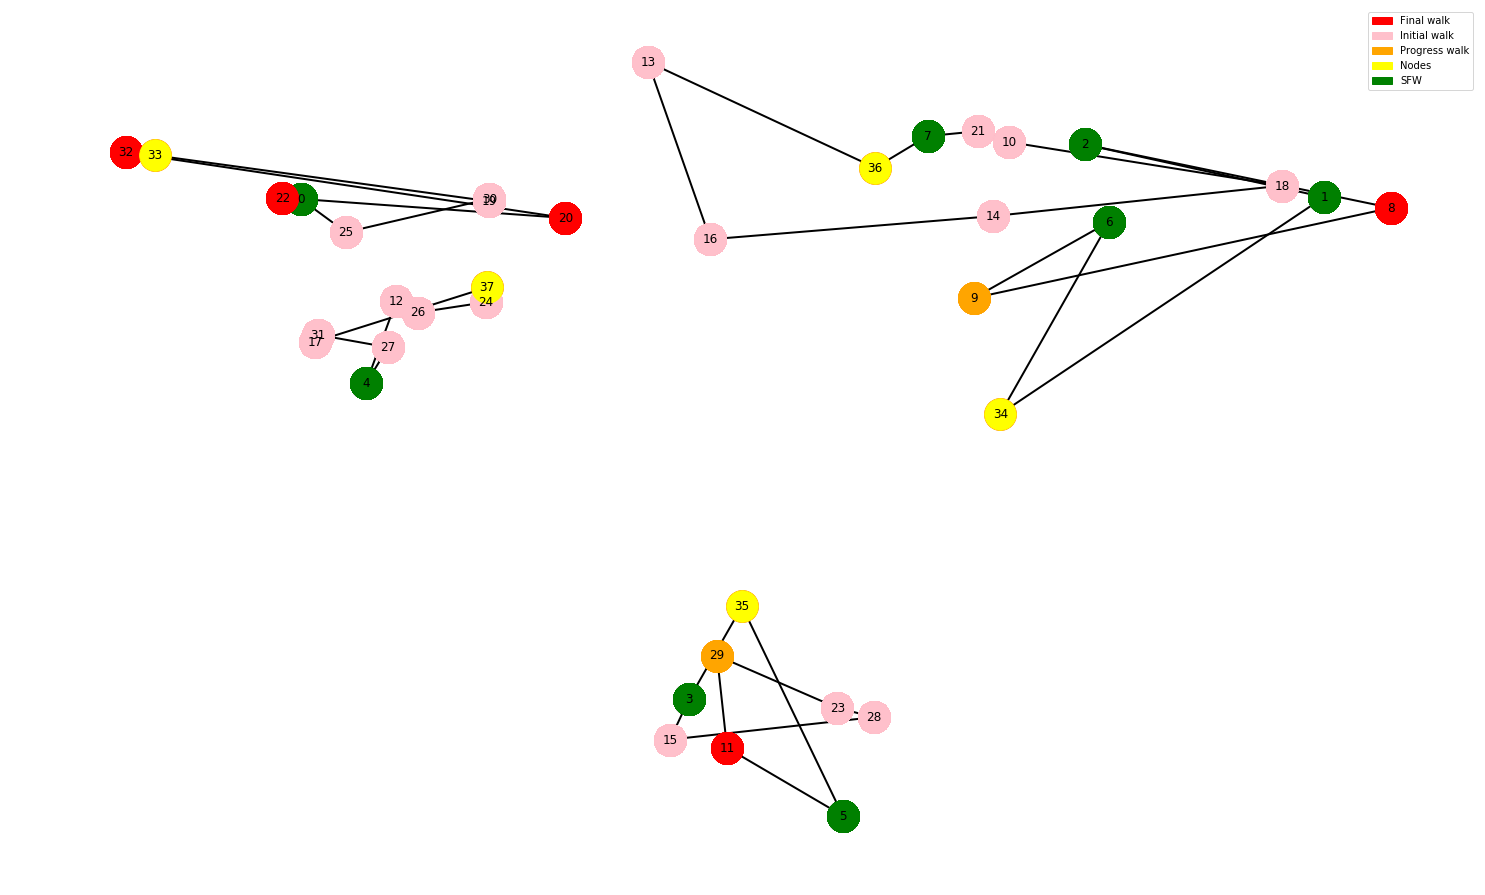

In [52]:
plt.figure(figsize=(20,12))
nx.draw(G, pos, with_labels=True, edge_color='white',node_size=1000)

sfw_list = []
final_walk_list =[]
progress_walk_list = []
initial_walk_list = []
for i in range(len(list_of_nodes)):
    if list_of_nodes[i][1] == 'sfw':
        sfw_list.append(list_of_nodes[i][0])
    elif list_of_nodes[i][1] == 'final walk':
        final_walk_list.append(list_of_nodes[i][0])
    elif list_of_nodes[i][1] == 'progress walk':
        progress_walk_list.append(list_of_nodes[i][0])
    else:
        initial_walk_list.append(list_of_nodes[i][0])
        
final_node_list = []
for k in range(5):
    final_node_list.append(animesh[k]["route"][0])
        
for i in range(5): 
    aa = animesh[i]['route']
    def pairwise(iterable):
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)
    edgelist = []
    for pair in pairwise(aa):
        edgelist.append(pair)
    edgelist = edgelist[:-1]
    nx.draw_networkx_edges(G,pos,edgelist=edgelist,width=2, alpha=1, edge_color='black',node_size=1000)
    ### For doing it manually
    
    #     nx.draw_networkx_edges(G,pos,edgelist=[(15, 15)],width=2, alpha=1, edge_color='g')
    #     nx.draw_networkx_edges(G,pos,edgelist=[(16, 12), (12, 7), (7, 3), (3, 8), (8, 2), (2, 16)],width=2, alpha=1, edge_color='purple')
    #     nx.draw_networkx_edges(G,pos,edgelist=[(17, 4), (4, 5), (5, 17)],width=2, alpha=1, edge_color='black')
    #     nx.draw_networkx_edges(G,pos,edgelist=[(18, 0), (0, 10), (10, 13), (13, 11), (11, 6), (6, 9), (9, 1) ,(1, 18)],width=2, alpha=1, edge_color='orange')
    #     #nx.draw_networkx_edges(G,pos,edgelist=[(0, 6), (6, 7), (7, 8), (8, 0)],width=2, alpha=1, edge_color='g')
    for j in range(len(list_of_nodes)):
        if (list_of_nodes[j][1] == 'sfw'):
            nx.draw_networkx_nodes(G, pos, node_color='green', node_size=1000, alpha=1, nodelist=sfw_list,label='green')
        elif (list_of_nodes[j][1] == 'final walk'):
            nx.draw_networkx_nodes(G, pos, node_color='red', node_size=1000, alpha=1, nodelist=final_walk_list,label='red')
        elif (list_of_nodes[j][1] == 'progress walk'):
            nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=1000, alpha=1, nodelist=progress_walk_list,label='orange')
        else:
            nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=1000, alpha=1, nodelist=initial_walk_list,label='pink')
        
nx.draw_networkx_nodes(G, pos, node_color='yellow', node_size=1000, alpha=1, nodelist=final_node_list,label='yellow')
### To print distances, uncomment this

# labels = nx.get_edge_attributes(G,'weight')
# newD = {k:round(v,2) for k, v in labels.items()}
# nx.draw_networkx_edge_labels(G,pos,edge_labels=newD)
# plt.axis('off')
# plt.show()

green_patch = mpatches.Patch(color='green', label='SFW')
red_patch = mpatches.Patch(color='red', label='Final walk')
orange_patch = mpatches.Patch(color='orange', label='Progress walk')
pink_patch = mpatches.Patch(color='pink', label='Initial walk')
yellow_patch = mpatches.Patch(color='yellow', label='Nodes')
plt.legend(handles=[red_patch,pink_patch,orange_patch,yellow_patch,green_patch])